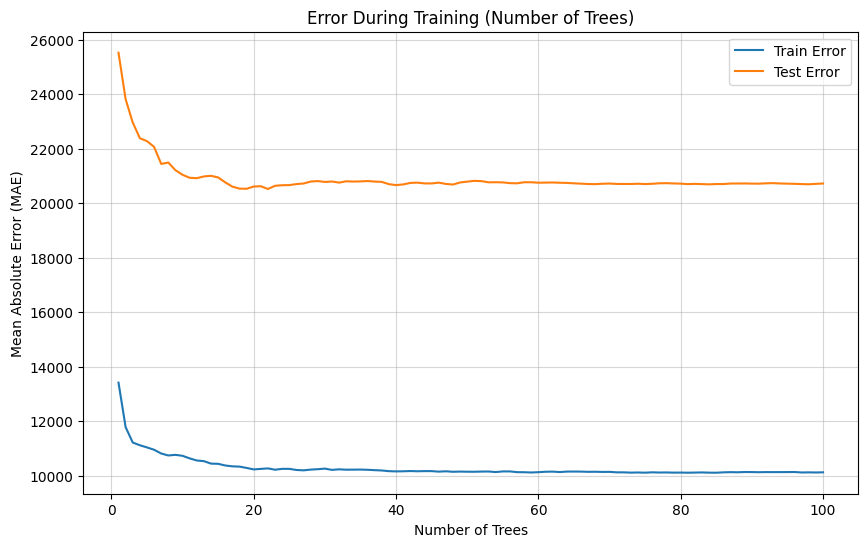


Final Results:
Train MAE: 10120.20, Train R²: 0.86
Test MAE: 20717.77, Test R²: 0.45


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# 1. Load and preprocess the data
file_path = 'modified_data.xlsx'  # Path to the Excel file
data = pd.read_excel(file_path)

# Remove duplicates
data = data.drop_duplicates()

# Filter apartments with specific criteria
data = data[
    (data['Property type_Apartments'] == 1) &  # Only apartments
    (data['Price'] <= 200000) &  # Price <= 200000
    (data['Gross area'] <= 250)  # Area <= 250 m²
]

# Normalize 'Year of construction'
scaler = MinMaxScaler()
data['Year of construction'] = scaler.fit_transform(data[['Year of construction']])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Separate target (y) and features (X)
X = data.drop(['Price'], axis=1)  # Exclude the target column
y = data['Price']  # Target variable

# Shuffle the data
data_shuffled = pd.concat([X, y], axis=1)
data_shuffled = shuffle(data_shuffled, random_state=42)

# Split the data into training and testing sets
X = data_shuffled.drop('Price', axis=1)
y = data_shuffled['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize variables for tracking errors
n_estimators = 100
train_errors = []
test_errors = []

# Train the Random Forest incrementally
rf_model = RandomForestRegressor(
    bootstrap=False, 
    max_depth=20, 
    max_features='sqrt', 
    min_samples_leaf=2, 
    min_samples_split=5, 
    warm_start=True,  # Allow incremental training
    random_state=42
)

for i in range(1, n_estimators + 1):
    rf_model.set_params(n_estimators=i)  # Incrementally increase the number of trees
    rf_model.fit(X_train, y_train)
    
    # Predict on training and test data
    train_pred = rf_model.predict(X_train)
    test_pred = rf_model.predict(X_test)
    
    # Calculate errors
    train_errors.append(mean_absolute_error(y_train, train_pred))
    test_errors.append(mean_absolute_error(y_test, test_pred))

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_errors, label="Train Error")
plt.plot(range(1, n_estimators + 1), test_errors, label="Test Error")
plt.title("Error During Training (Number of Trees)")
plt.xlabel("Number of Trees")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Final evaluation
final_train_pred = rf_model.predict(X_train)
final_test_pred = rf_model.predict(X_test)

final_mae_train = mean_absolute_error(y_train, final_train_pred)
final_mae_test = mean_absolute_error(y_test, final_test_pred)
final_r2_train = r2_score(y_train, final_train_pred)
final_r2_test = r2_score(y_test, final_test_pred)

print("\nFinal Results:")
print(f"Train MAE: {final_mae_train:.2f}, Train R²: {final_r2_train:.2f}")
print(f"Test MAE: {final_mae_test:.2f}, Test R²: {final_r2_test:.2f}")


## Additional Visualizations for the Random Forest Model

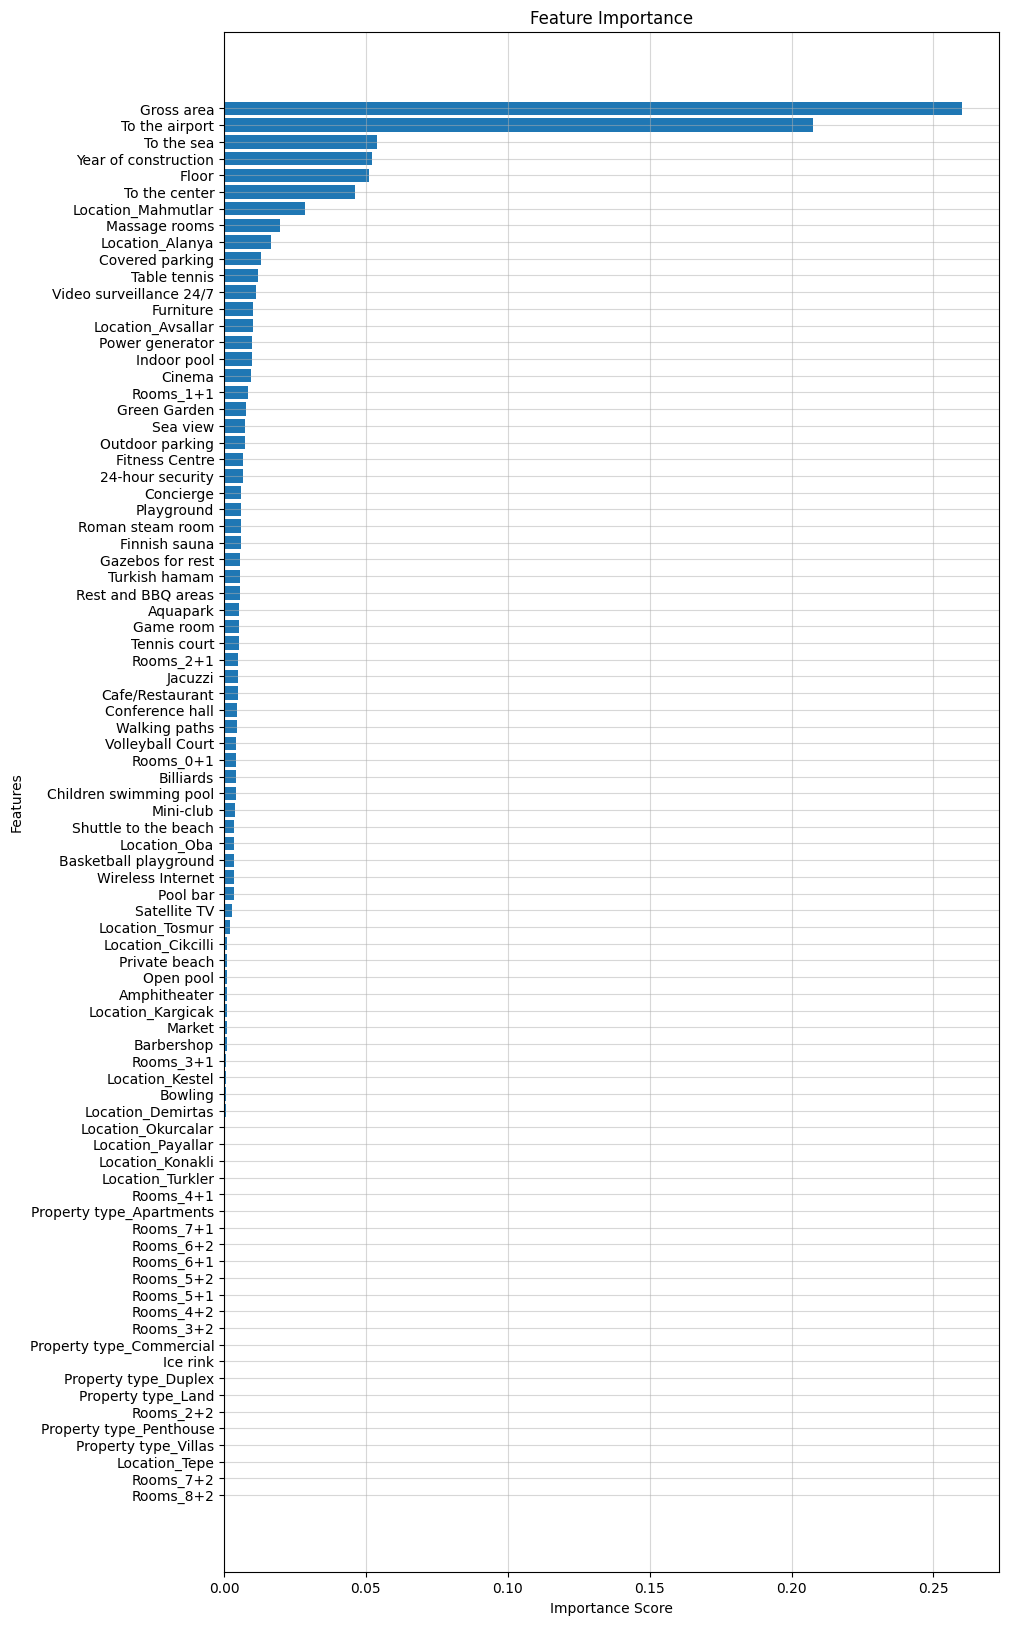

In [11]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = importances.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.show()


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

## Predictions vs. True Values

This compares the model’s predictions to the actual values for the test set.



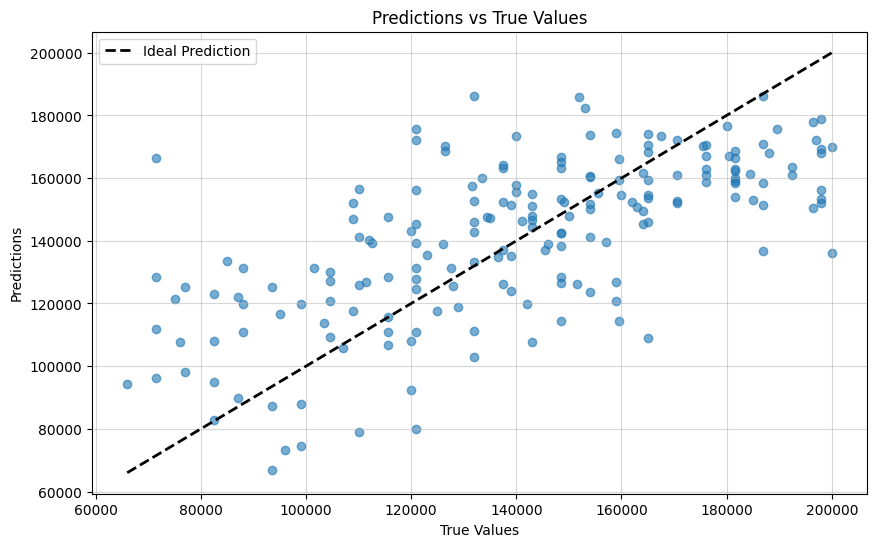

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Prediction")
plt.title("Predictions vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

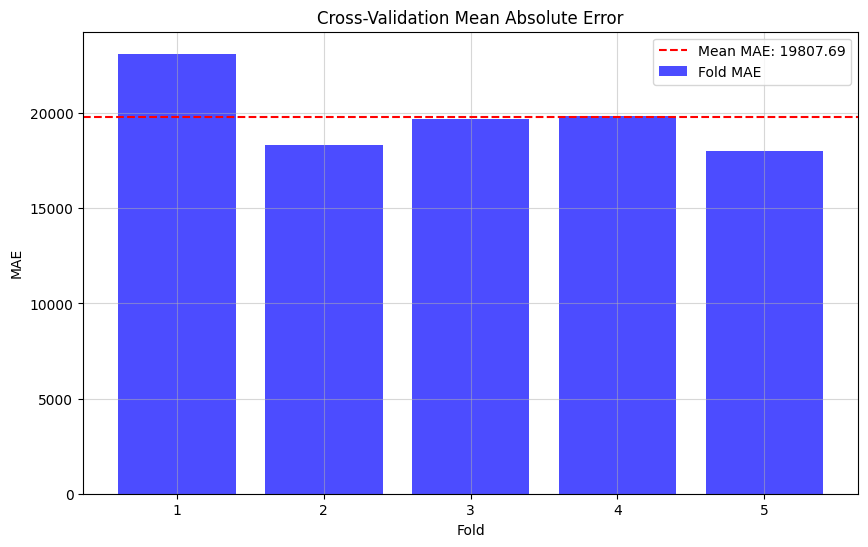


Final Results:
Cross-Validation Mean MAE: 19807.69
Test MAE: 20717.77, Test R²: 0.45


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# 1. Load and preprocess the data
file_path = 'modified_data.xlsx'  # Path to the Excel file
data = pd.read_excel(file_path)

# Remove duplicates
data = data.drop_duplicates()

# Filter apartments with specific criteria
data = data[
    (data['Property type_Apartments'] == 1) &  # Only apartments
    (data['Price'] <= 200000) &  # Price <= 200000
    (data['Gross area'] <= 250)  # Area <= 250 m²
]

# Normalize 'Year of construction'
scaler = MinMaxScaler()
data['Year of construction'] = scaler.fit_transform(data[['Year of construction']])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Separate target (y) and features (X)
X = data.drop(['Price'], axis=1)  # Exclude the target column
y = data['Price']  # Target variable

# Shuffle the data
data_shuffled = pd.concat([X, y], axis=1)
data_shuffled = shuffle(data_shuffled, random_state=42)

# Split the data into training and testing sets
X = data_shuffled.drop('Price', axis=1)
y = data_shuffled['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Random Forest model with best parameters
rf_model = RandomForestRegressor(
    bootstrap=False, 
    max_depth=20, 
    max_features='sqrt', 
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=100, 
    random_state=42
)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_mean = -cv_scores.mean()  # Convert negative MAE to positive

# Train the model on the full training set
rf_model.fit(X_train, y_train)

# Predict on test data
final_test_pred = rf_model.predict(X_test)

# Calculate test errors
final_mae_test = mean_absolute_error(y_test, final_test_pred)
final_r2_test = r2_score(y_test, final_test_pred)

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), -cv_scores, alpha=0.7, color='blue', label='Fold MAE')
plt.axhline(cv_scores_mean, color='red', linestyle='--', label=f'Mean MAE: {cv_scores_mean:.2f}')
plt.title("Cross-Validation Mean Absolute Error")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Final evaluation
print("\nFinal Results:")
print(f"Cross-Validation Mean MAE: {cv_scores_mean:.2f}")
print(f"Test MAE: {final_mae_test:.2f}, Test R²: {final_r2_test:.2f}")
